In [12]:
import numpy as np 
import pandas as pd
from os import walk
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson as poisson_scipy


In [15]:
_, _, filenames = next(walk('geiger1'))

In [18]:
data=np.loadtxt('geiger1/'+filenames[0])[:,1]
data.shape

(500,)

In [21]:
def var_experimental(X):
   return  (len(X)-1)**-1.*sum((X-X.mean())**2)

In [24]:
STATS=np.zeros((len(filenames),3))

for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    STATS[i,0]=data.mean()
    STATS[i,1]=(data.mean()/len(data))**0.5
    STATS[i,2]=var_experimental(data)

df=pd.DataFrame(STATS, columns=['media','erro_media','variancia'])
df.index=filenames
# df.to_csv('media_variancia.txt', sep=' ')

Text(0.5, 0.98, '\nDistruibuição dos Dados Brutos')

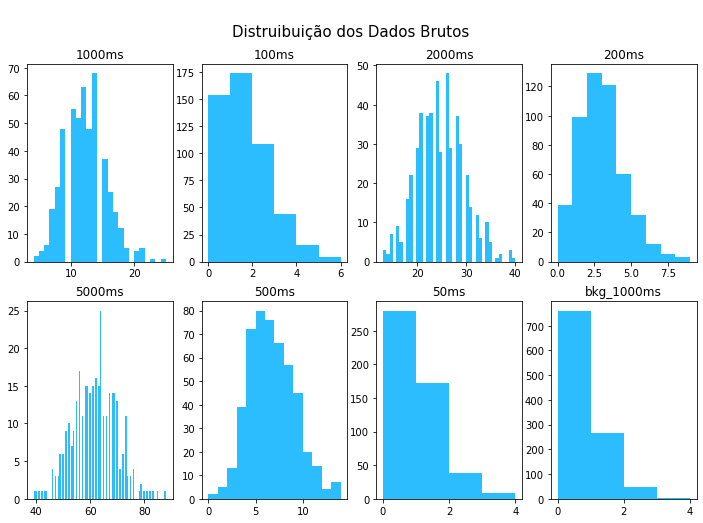

In [27]:
Blue = '#2CBDFE'

fig, ax=plt.subplots(2,4,figsize=(12,8))
for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    dt=filenames[i].split('.')[0]
    ax[int(i/4),int(i%4)].hist(data,bins=int(max(data)),color=Blue)
    ax[int(i/4),int(i%4)].set_title(dt)
fig.suptitle('\nDistruibuição dos Dados Brutos',fontsize=15)
# plt.savefig('fig_dist_dados_brutos_v1.png')


In [29]:
# Poisson distribution
#std=mean

def poisson(x,lamb):
   return  poisson_scipy.pmf(x,lamb)#(mean**x)*np.exp(-mean)*1./np.math.factorial(x)

def poisson_log_likelihood_estimation(X,lamb):

    return -1.*float(len(X))*lamb+np.log(lamb)*sum(X)-sum(log_factorial(X))

def log_factorial(x):
    return sum(np.log(np.arange(1,x+1)))

log_factorial=np.vectorize(log_factorial)
# Gaussian distribution

#std=mean

def gaussian(x,mean,std):

    return (np.pi*2.*std**2.)**-0.5*np.exp(-(x-mean)**2./(2.*std**2))

def gaussian_log_likelihood_estimation(X,std):
    return -float(len(X))/2.*(np.log(2*np.pi*std**2)+1)    

def chi_2_over_freedom_degrees(X,mean,var,n_parameters):
    N=int(len(X))
    return (N-1)*var*1./(mean*(N-n_parameters))

gaussian_vec=np.vectorize(gaussian)
poisson_vec=np.vectorize(poisson)

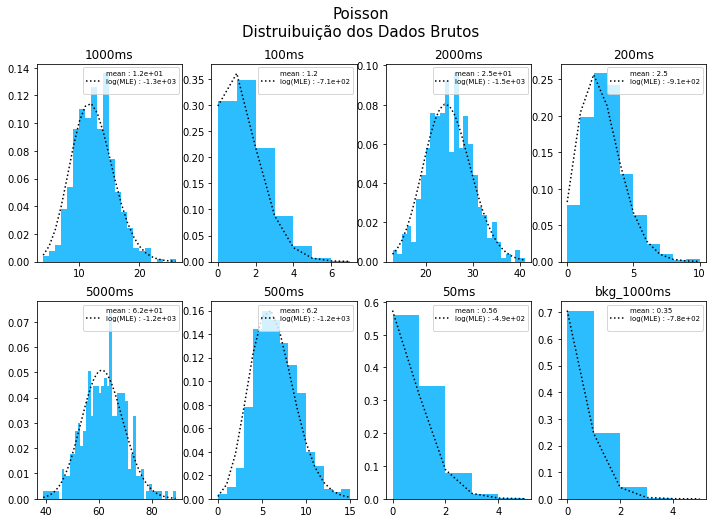

In [31]:
#poisson mle

Blue = '#2CBDFE'
mle_poisson=np.zeros(len(filenames))

fig, ax=plt.subplots(2,4,figsize=(12,8))
for i in range(0,len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    dt=filenames[i].split('.')[0]

    X=np.arange(int(min(data)),int(max(data))+2)  
    mean=STATS[i,0]
   
    mle=poisson_log_likelihood_estimation(data,mean)
    mle_poisson[i]=mle
    

    ax[int(i/4),int(i%4)].hist(data,bins=X,color=Blue,density=True)

    ax[int(i/4),int(i%4)].plot(X,poisson(X,mean),linestyle='dotted',color='black',label='mean : {:.2}\nlog(MLE) : {:.2}\n'.format(mean,mle))

    ax[int(i/4),int(i%4)].legend(fontsize=7)
    ax[int(i/4),int(i%4)].set_title(dt)
fig.suptitle('Poisson\nDistruibuição dos Dados Brutos',fontsize=15)

plt.savefig('fig_poisson_lme_dist_dados_brutos_v1.png')


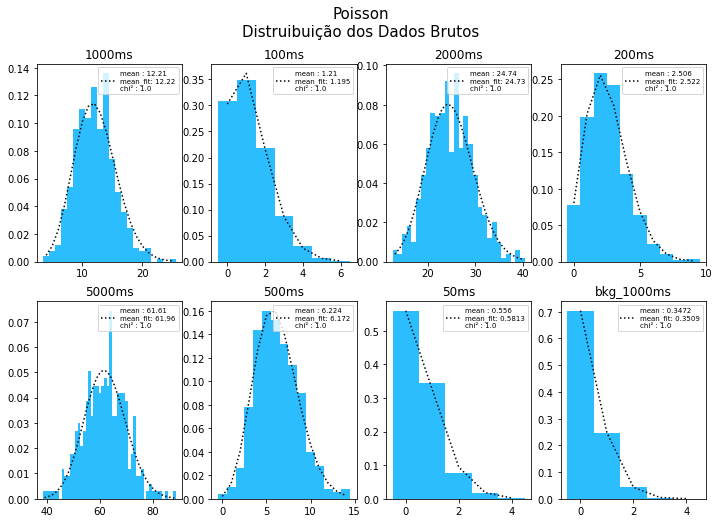

In [33]:
###poisson chi2

Blue = '#2CBDFE'
chi_poisson=np.zeros(len(filenames))
parameters_poisson=np.zeros(len(filenames))
fig, ax=plt.subplots(2,4,figsize=(12,8))
for i in range(0,len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    dt=filenames[i].split('.')[0]

    X=np.arange(int(min(data))-1,int(max(data))+1)+0.5  
    mean=STATS[i,0]
    var=mean
    chi2=chi_2_over_freedom_degrees(X,mean,var,1)
    chi_poisson[i]=chi2

    freq,bin_edges,_=ax[int(i/4),int(i%4)].hist(data,bins=X,color=Blue,density=True)
    bin_middles=0.5 * (bin_edges[1:] + bin_edges[:-1])

    parameters,cov_matrix=curve_fit(poisson_vec,bin_middles,freq,p0=mean)
    ax[int(i/4),int(i%4)].plot(bin_middles,poisson_vec(bin_middles,parameters[0]),linestyle='dotted',color='black',label='mean : {:.4}\nmean_fit: {:.4}\nchi² : {:.4}'.format(mean,parameters[0],chi2))
    parameters_poisson[i]=parameters
    ax[int(i/4),int(i%4)].legend(fontsize=7)
    ax[int(i/4),int(i%4)].set_title(dt)
fig.suptitle('Poisson\nDistruibuição dos Dados Brutos',fontsize=15)
plt.savefig('fig_poisson_minimos_quad_dist_dados_brutos_v1.png')


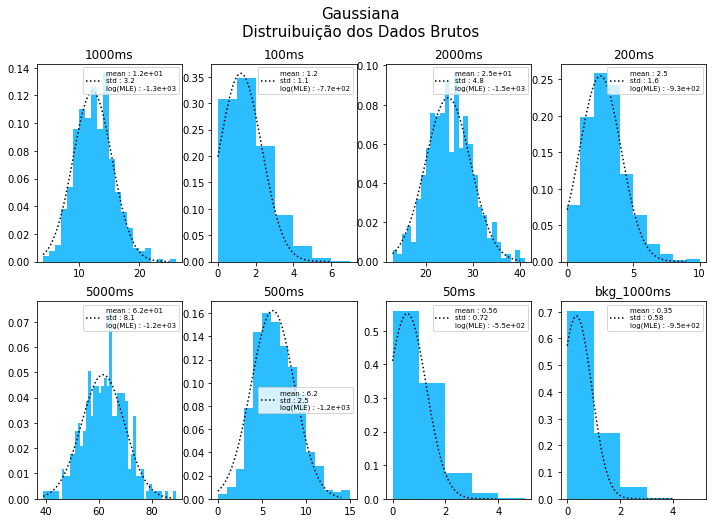

In [35]:
Blue = '#2CBDFE'
mle_gaussian=np.zeros(len(filenames))

fig, ax=plt.subplots(2,4,figsize=(12,8))
for i in range(len(filenames)):

    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    dt=filenames[i].split('.')[0]
    mean=STATS[i,0] 
    var=STATS[i,2]
    std=var**0.5

    mle=gaussian_log_likelihood_estimation(data,std)
    mle_gaussian[i]=mle

    

    X=np.linspace(min(data),max(data),100)
    ax[int(i/4),int(i%4)].plot(X,gaussian(X,mean,std),linestyle='dotted',color='black',label='mean : {:.2}\nstd : {:.2}\nlog(MLE) : {:.2}'.format(mean,std,mle))
    BIN=np.arange(int(min(data)),int(max(data))+2)  
    ax[int(i/4),int(i%4)].hist(data,bins=BIN,color=Blue,density=True)
    ax[int(i/4),int(i%4)].legend(fontsize=7)
    ax[int(i/4),int(i%4)].set_title(dt)
fig.suptitle('Gaussiana\nDistruibuição dos Dados Brutos',fontsize=15)

plt.savefig('fig_gaussiana_lme_dist_dados_brutos_v1.png')


[0.71472792 0.52182669] 0.3472222222222222 0.5830408817192452


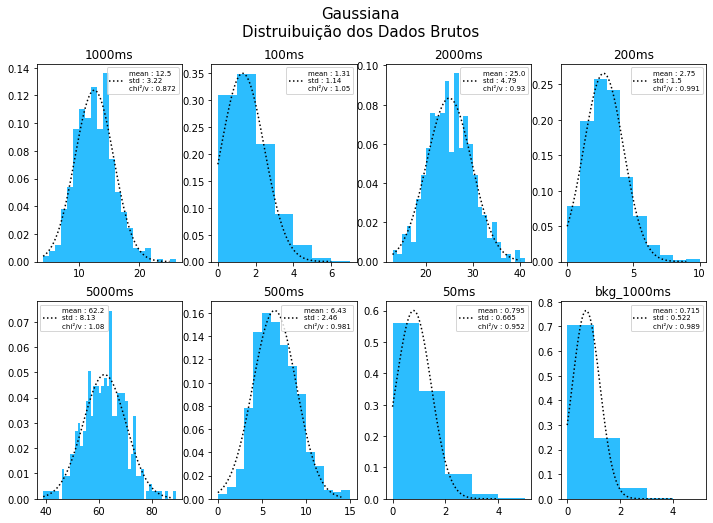

In [37]:
Blue = '#2CBDFE'
chi_gaussian=np.zeros(len(filenames))
parameters_gaussian=np.zeros((len(filenames),2))
fig, ax=plt.subplots(2,4,figsize=(12,8))
for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    dt=filenames[i].split('.')[0]
    mean=STATS[i,0] # valor da média que eu já tinah calculado
    var=STATS[i,2]# valor da variancia que eu já tinha calculado
    std=var**0.5


    X=np.linspace(min(data),max(data),100)

    chi2=chi_2_over_freedom_degrees(X,mean,var,2)
    chi_gaussian[i]=chi2
    

    BIN=np.arange(int(min(data)),int(max(data))+2)  
    
    freq,bin_edges,_=ax[int(i/4),int(i%4)].hist(data,bins=BIN,color=Blue,density=True)
    bin_middles=0.5 * (bin_edges[1:] + bin_edges[:-1])

    parameters,cov_matrix=curve_fit(gaussian,bin_middles,freq,p0=[mean,std])
    parameters_gaussian[i,:]=parameters

    ax[int(i/4),int(i%4)].plot(X,gaussian(X,parameters[0],parameters[1]),linestyle='dotted',color='black',label='mean : {:.3}\nstd : {:.3}\nchi²/v : {:.3}'.format(parameters[0],parameters[1],chi2))
    ax[int(i/4),int(i%4)].legend(fontsize=7)
    ax[int(i/4),int(i%4)].set_title(dt)
fig.suptitle('Gaussiana\nDistruibuição dos Dados Brutos',fontsize=15)

plt.savefig('fig_gaussiana_minimos_quad_dist_dados_brutos_v1.png')
print(parameters,mean,std)

Text(0.5, 0.98, 'Função que Maximiza a estimativa da Log likelihood \nDistruibuição dos Dados Brutos')

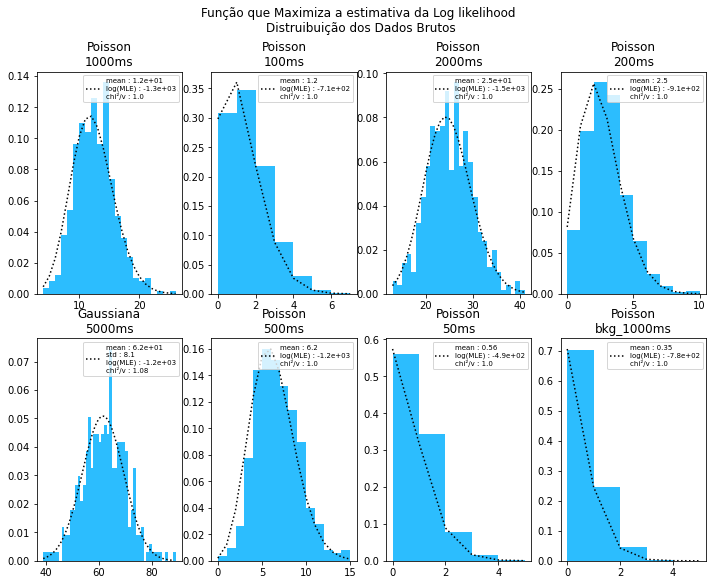

In [38]:
fig, ax=plt.subplots(2,4,figsize=(12,9))

for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    mean=STATS[i,0]
    dt=filenames[i].split('.')[0]

    if mle_poisson[i]>mle_gaussian[i]:
            X=np.arange(min(data),int(max(data))+2)
            ax[int(i/4),int(i%4)].plot(X,poisson(X,mean),linestyle='dotted',color='black',label='mean : {:.2}\nlog(MLE) : {:.2}\nchi²/v : {:.3}'.format(mean,mle_poisson[i],chi_poisson[i]))
            ax[int(i/4),int(i%4)].hist(data,bins=X,color=Blue,density=True)
            ax[int(i/4),int(i%4)].legend(fontsize=7)
            ax[int(i/4),int(i%4)].set_title('Poisson\n'+dt)
    else:
            std=mean**0.5
            X=np.linspace(min(data),max(data),100)
            ax[int(i/4),int(i%4)].plot(X,gaussian(X,mean,std),linestyle='dotted',color='black',label='mean : {:.2}\nstd : {:.2}\nlog(MLE) : {:.2}\nchi²/v : {:.3}'.format(mean,STATS[i,2]**0.5,mle_gaussian[i],chi_gaussian[i]))
            BIN=np.arange(int(min(data)),int(max(data))+2)  
            ax[int(i/4),int(i%4)].hist(data,bins=BIN,color=Blue,density=True)
            ax[int(i/4),int(i%4)].legend(fontsize=7)
            ax[int(i/4),int(i%4)].set_title('Gaussiana\n'+dt)

fig.suptitle('Função que Maximiza a estimativa da Log likelihood \nDistruibuição dos Dados Brutos')
#plt.savefig('fig_melhor_funcao_lme_dist_dados_brutos_v1.png')


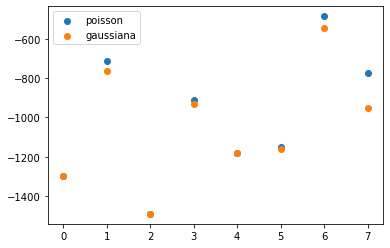

In [43]:
plt.scatter(np.arange(len(mle_poisson)),mle_poisson,label='poisson')
plt.scatter(np.arange(len(mle_poisson)),mle_gaussian,label='gaussiana')
plt.legend()

prob 0.024993882139382893
prob 0.002389792060070928
prob 0.049989451949994546
prob 0.005498836205283558
prob 0.184406060657272
prob 0.012866542090034296
prob 0.0015902654813788834
prob 0.0006617851078882927


Text(0.5, 0.98, 'Função que Maximiza a estimativa da Log likelihood \nDistruibuição dos Dados Brutos')

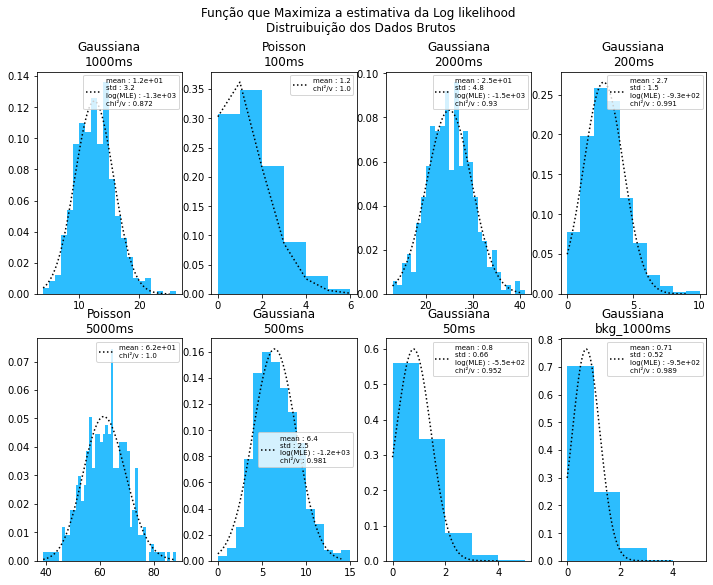

In [46]:
fig, ax=plt.subplots(2,4,figsize=(12,9))

for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    mean=STATS[i,0]
    dt=filenames[i].split('.')[0]

    if chi_poisson[i]<chi_gaussian[i]:
            X=np.arange(int(min(data)),int(max(data))+1)
            ax[int(i/4),int(i%4)].plot(X,poisson(X,parameters_poisson[i]),linestyle='dotted',color='black',label='mean : {:.2}\nchi²/v : {:.3}'.format(parameters_poisson[i],chi_poisson[i]))
            ax[int(i/4),int(i%4)].hist(data,bins=X,color=Blue,density=True)
            ax[int(i/4),int(i%4)].legend(fontsize=7)
            ax[int(i/4),int(i%4)].set_title('Poisson\n'+dt)

    else:
            std=mean**0.5
            X=np.linspace(min(data),max(data),100)
            ax[int(i/4),int(i%4)].plot(X,gaussian(X,parameters_gaussian[i,0],parameters_gaussian[i,1]),linestyle='dotted',color='black',label='mean : {:.2}\nstd : {:.2}\nlog(MLE) : {:.2}\nchi²/v : {:.3}'.format(parameters_gaussian[i,0],parameters_gaussian[i,1],mle_gaussian[i],chi_gaussian[i]))
            BIN=np.arange(int(min(data)),int(max(data))+2)  
            ax[int(i/4),int(i%4)].hist(data,bins=BIN,color=Blue,density=True)
            ax[int(i/4),int(i%4)].legend(fontsize=7)
            ax[int(i/4),int(i%4)].set_title('Gaussiana\n'+dt)
fig.suptitle('Função que Maximiza a estimativa da Log likelihood \nDistruibuição dos Dados Brutos')
# plt.savefig('fig_melhor_funcao_chi2_dist_dados_brutos_v1.png')


In [57]:
dt=[int(filenames[i].split('ms')[0]) for i in range(len(filenames)-1)]
dt

[1000, 100, 2000, 200, 5000, 500, 50]

In [87]:
decay_rate=np.vstack((STATS[:-1,0]/dt,STATS[:-1,1]/dt))
decay_rate=decay_rate.transpose()
decay_rate

array([[1.22080000e-02, 1.56256200e-04],
       [1.21000000e-02, 4.91934955e-04],
       [1.23720000e-02, 1.11229492e-04],
       [1.25300000e-02, 3.53977400e-04],
       [1.23220238e-02, 8.56419172e-05],
       [1.24480000e-02, 2.23141211e-04],
       [1.11200000e-02, 6.66933280e-04]])

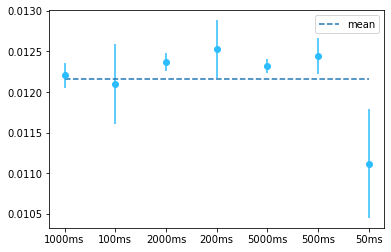

In [111]:
labels=[filenames[i].split('.')[0] for i in range(len(filenames)-1)]
plt.errorbar(labels,decay_rate[:,0],yerr=decay_rate[:,1],color=Blue,fmt='o')
mean_decays=np.ones(7)*decay_rate[:,0].mean()
plt.plot(labels,mean_decays,linestyle='dashed',label='mean')
error_mean=(decay_rate[:,0].mean()/len(dt))**0.5
# plt.fill_between(labels,mean_decays-error_mean,mean_decays+error_mean)
plt.legend()

In [122]:
ccd_data=np.loadtxt('ativo1.txt')
ccd_overscan=np.loadtxt('overscan.txt')

(array([  4.,   1.,   2.,   3.,  13.,  25.,  36.,  45.,  63.,  86., 101.,
        107., 152., 243., 274., 354., 397., 443., 540., 597., 595., 694.,
        677., 717., 688., 719., 633., 627., 536., 497., 429., 365., 312.,
        247., 203., 149., 111.,  97.,  59.,  42.,  40.,  25.,  18.,  12.,
          9.,   5.,   2.,   3.,   0.,   3.]),
 array([-41.529   , -39.788588, -38.048176, -36.307764, -34.567352,
        -32.82694 , -31.086528, -29.346116, -27.605704, -25.865292,
        -24.12488 , -22.384468, -20.644056, -18.903644, -17.163232,
        -15.42282 , -13.682408, -11.941996, -10.201584,  -8.461172,
         -6.72076 ,  -4.980348,  -3.239936,  -1.499524,   0.240888,
          1.9813  ,   3.721712,   5.462124,   7.202536,   8.942948,
         10.68336 ,  12.423772,  14.164184,  15.904596,  17.645008,
         19.38542 ,  21.125832,  22.866244,  24.606656,  26.347068,
         28.08748 ,  29.827892,  31.568304,  33.308716,  35.049128,
         36.78954 ,  38.529952,  40.270364,  4

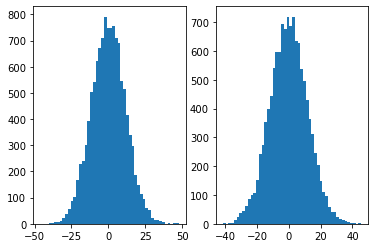

In [129]:
fig,ax=plt.subplots(1,2)
ax[0].hist(ccd_overscan,bins=50)
ax[1].hist(ccd_data,bins=50)